In [1]:
import pandas as pd
import datasets
import evaluate
import numpy as np

/data/vision/polina/shared_software/miniconda3/envs/cxrpe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

In [3]:
os.environ['CUDA_VISIBLE_DEVICES']

'0'

In [4]:
# Loading huggingface 
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [5]:
df1 = pd.read_csv('/data/vision/polina/scratch/barbaralam/cxrpe/data/Modeling/CXRneg48.csv')
df2 = pd.read_csv('/data/vision/polina/scratch/barbaralam/cxrpe/data/Modeling/CXRpos48.csv')

# convert 'PE' from bool to int
df1['Type_of_PE'] = 0
df2['Type_of_PE'] = 1

Np = len(df2)
df1 = df1.sample(n=Np, random_state=42)

df = pd.concat([df1, df2], axis=0)
cols = {'text_y': 'text', 'Type_of_PE': 'label'}
df = df[list(cols.keys())].rename(columns=cols)
len(df)

1106

In [6]:
# This converts your dataframe to datasets and shows you the first 3 rows
ds = datasets.Dataset.from_pandas(df, preserve_index=False)
ds = ds.train_test_split(test_size=0.3)
ds['train'][:3]

{'text': ['                                 FINAL REPORT\n HISTORY:  Possible pneumonia or fluid overload.\n \n FINDINGS:  In comparison with the study of ___, there is again enlargement of\n the cardiac silhouette with pulmonary vascular congestion and bilateral\n pleural effusions with compressive atelectasis at the bases.\n \n Monitoring and support devices remain in place.\n',
  '                                 FINAL REPORT\n EXAMINATION:  CHEST (PORTABLE AP)\n \n INDICATION:  ___ year old woman with new ETT  // Confirm placement\n \n COMPARISON:  ___.\n \n IMPRESSION: \n \n As compared to the previous radiograph, the patient has received a nasogastric\n tube. The tip of the tube projects over the pre-pyloric region of the stomach.\n The course of the tube is unremarkable. The patient has also been intubated.\n The tip of the endotracheal tube is approximately 1 cm above the carinal, next\n to the orifice of the right main bronchus. The tube should be pulled back by 2\n cm.  No ev

In [7]:
def extract_findings_and_impression(example):
    report = example['text']
    from section_parser import section_text
    sections, section_names, section_idx = section_text(report)
    d = dict(zip(section_names, sections))
    s = ''
    if 'findings' in d:
        s += d['findings'] + '\n'
    if 'impression' in d:
        s += d['impression'] + '\n'
    s = s.strip()
    return {'text_findings_and_impression': s}

ds = ds.map(extract_findings_and_impression)
ds

Map: 100%|██████████| 332/332 [00:00<00:00, 8326.81 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'text_findings_and_impression'],
        num_rows: 774
    })
    test: Dataset({
        features: ['text', 'label', 'text_findings_and_impression'],
        num_rows: 332
    })
})

In [8]:
# This identifies which model you want to use
model_name = "distilbert/distilbert-base-uncased"
model_name = "emilyalsentzer/Bio_ClinicalBERT"

In [9]:
# This converts text to tokens
def preprocess_function(examples):
    return tokenizer(examples["text_findings_and_impression"], truncation=True) # , max_length=256

tokenizer = AutoTokenizer.from_pretrained(model_name)
train_ds = ds.map(preprocess_function, batched=True)

Map: 100%|██████████| 332/332 [00:00<00:00, 8099.80 examples/s]


In [10]:
train_ds = train_ds.map(lambda x: {'input_ids_len': len(x['input_ids'])})
train_ds

Map: 100%|██████████| 332/332 [00:00<00:00, 6132.05 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'text_findings_and_impression', 'input_ids', 'token_type_ids', 'attention_mask', 'input_ids_len'],
        num_rows: 774
    })
    test: Dataset({
        features: ['text', 'label', 'text_findings_and_impression', 'input_ids', 'token_type_ids', 'attention_mask', 'input_ids_len'],
        num_rows: 332
    })
})

(array([ 32.,  22., 136., 175., 132., 111.,  69.,  42.,  23.,  21.,   4.,
          4.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  2.  ,  22.75,  43.5 ,  64.25,  85.  , 105.75, 126.5 , 147.25,
        168.  , 188.75, 209.5 , 230.25, 251.  , 271.75, 292.5 , 313.25,
        334.  , 354.75, 375.5 , 396.25, 417.  ]),
 <BarContainer object of 20 artists>)

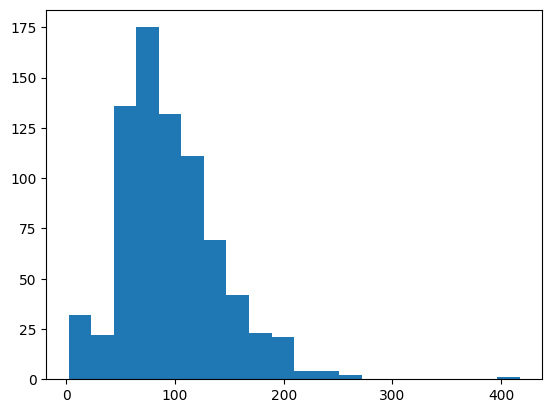

In [11]:
import matplotlib.pyplot as plt

plt.hist(train_ds['train']['input_ids_len'], bins=20)

In [11]:
# Showing the tokenization of the first row in the text column
train_ds['train'][0]

{'text': '                                 FINAL REPORT\n EXAMINATION:  CHEST (PORTABLE AP)\n \n INDICATION:  ___ year old woman s/p LULobectomy. Persistent desats in ICU,\n ongoing BiPAP, minimal respiratory effort.  // eval infiltrate\n \n COMPARISON:  ___\n \n IMPRESSION: \n \n As compared to the previous radiograph, no relevant change is seen. The\n extensive right parenchymal opacities as well as the relatively extensive\n postoperative left upper lung consolidations are constant in extent and\n severity. Unchanged size of the cardiac silhouette. Unchanged normal\n monitoring and support devices.\n',
 'label': 0,
 'input_ids': [101,
  1509,
  2592,
  8179,
  131,
  2229,
  113,
  15139,
  170,
  1643,
  114,
  12754,
  131,
  168,
  168,
  168,
  1214,
  1385,
  1590,
  188,
  120,
  185,
  181,
  22806,
  3962,
  5822,
  18574,
  119,
  15970,
  3532,
  9971,
  1107,
  178,
  10182,
  117,
  7173,
  16516,
  4163,
  1643,
  117,
  10298,
  19192,
  3098,
  119,
  120,
  120,
  17

In [12]:
# Pulls your data together into your batch size as input into the model
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
# Set which evaluation metrics you want to use
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [14]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
training_args = TrainingArguments(
    output_dir="results/note_text_classifier",
    learning_rate=2e-4,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds["train"],
    eval_dataset=train_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

train_result = trainer.train()

/data/vision/polina/shared_software/miniconda3/envs/cxrpe/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.814706,0.503012
2,No log,0.695901,0.503012
3,No log,0.756275,0.496988
4,No log,0.701322,0.496988
5,No log,0.696394,0.503012
6,No log,0.750228,0.496988
7,No log,0.693353,0.496988
8,0.713600,0.699391,0.503012
9,0.713600,0.696094,0.496988
10,0.713600,0.693171,0.496988


In [35]:
! nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fri Apr 12 17:25:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:3B:00.0 Off |                  N/A |
| 32%   31C    P8              19W / 250W |   5575MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--